### 1. Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#unzip the zip file to link it with this program
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./drive/My Drive/acse-miniproject.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 1s (267 kB/s)
Reading package lists... Done
Reading package lists... Done
Building d

In [3]:
#livelossplot setup
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# imports
# random seed set function
# check device
# function to apply transforms -- CustomImageTensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
import torch.optim as optim

import glob
from PIL import Image
import numpy as np
import pandas as pd
import json 

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
    

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        #sample = sample.view(3, 64, 63).float()/255.
        if self.transform:
            sample = self.transform(sample)


        return sample, label

Cuda installed! Running on GPU!


In [0]:
# To check the situation of the GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [0]:
# To check the amount of the available RAM
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

### 2. Path sign, Model select and Other Hyperparameters

In [0]:
# path of output .pth and .csv
save_path = "/content/drive/My Drive/"

In [0]:
#  resnet101 > wideresnet_101 > inception_v3 > resnet50

params = {
    'resnetwide_101': {
        'lr' : 0.1,
        'weight_decay': 1e-8，
        'momentum': 0.2 ,
        'batch_size': 32,
        'adap': True
    },
    'resnet_101': {
        'lr': 0.1,
        'weight_decay': 2e-4,
        'momentum': 0.9 ,
        'batch_size': 64,
        'adap': True
    },
    'renet_50': {
        'lr' : 0.1,
        'weight_decay': 1e-5,
        'momentum': 0.9,
        'batch_size': 64,
        'adap': True
    },
    'inception_v3': {
        'lr' : 0.01,
        'weight_decay': 0,
        'momentum': 0.9,
        'batch_size': 64,
        'adap': False
    }
    
}

In [26]:
# Other Hyperparameters
seed = 42
test_batch_size = 1000
n_epochs = 30

model_name = 'resnetwide_101' #our best model

if model_name == 'resnetwide_101': 
    model = models.wide_resnet101_2(pretrained=True),
if model_name == 'resnet_101':  
    model = models.resnet101(pretrained=True),
if model_name == 'renet_50':  
    model = models.wide_resnet50_2(pretrained=True),
if model_name == 'inception_v3':  
    model = models.inception_v3(pretrained=True)

model = models.resnet101(pretrained=True)
lr = params[model_name]['lr']
weight_decay = params[model_name]['weight_decay']
momentum = params[model_name]['momentum']
batch_size = params[model_name]['batch_size']
adap = params[model_name]['adap']

print('model:',model_name, ' learning rate:', lr, " weight_decay:", weight_decay, ' momentum: ', momentum, ' batch size: ', batch_size)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth



model: resnetwide_101  learning rate: 0.1  weight_decay: 0  momentum:  0.2  batch size:  32


### 3. Data Processing

##### Import training data, and preprocessing

In [8]:
# path of training data
train_data_path = './train'  #path for kaggle: '/kaggle/input/acse-miniproject/train' 

# find all image file
# path for kaggle: '/kaggle/input/acse-miniproject/mapping.json' 
with open("./mapping.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)

        
train_file = glob.glob(train_data_path+'/*/images/*.JPEG')
print("load file name sucess! number of images found: ",len(train_file))


# convert all images to "RGB" with 3 channels
# check labels
train_data = []
labels = []
for f in train_file:
    img = np.array(Image.open(f))
    label_name = f.split('/')[2] #kaggle: [5] 
    label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = Image.fromarray(np.uint8(img))
        img = np.asarray(img.convert('RGB'))
    
    train_data.append(img)
    labels.append(label)

#convert to numpy array
train_data = np.array(train_data)
labels = np.array(labels)
print("Size of train data feature: ",train_data.shape)
print("Szie of train data labels", labels.shape)
del train_file

load file name sucess! number of images found:  100000
Size of train data feature:  (100000, 64, 64, 3)
Szie of train data labels (100000,)


In [9]:
# Calculate mean and std, since it is fixed for given data, don't have to calculate all the time

# mean = train_data.mean(axis=(0,1,2))/255
# std = train_data.std(axis=(0,1,2))/255
mean=[0.4802, 0.4481, 0.3975]
std=[0.2770, 0.2691, 0.2821]

print("mean: ", mean)
print("std: ", std)

mean:  [0.4802, 0.4481, 0.3975]
std:  [0.277, 0.2691, 0.2821]


#### Shuffle data, split validation and training

In [10]:
# shuffle the data of validation and train to size 1:9
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, labels)

indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

print("number of train data:", len(indices[0]))
print("number of validation data:", len(indices[1]))

X_train, y_train = torch.tensor(train_data[indices[0]]).float(), torch.tensor(labels)[indices[0]]
X_val, y_val = torch.tensor(train_data[indices[1]]).float(), torch.tensor(labels)[indices[1]]

# convert the data to shape in (samples, channel, dim_x, dim_y)
X_train = X_train.permute(0,3,1,2)
X_val = X_val.permute(0,3,1,2)


print("train: ", X_train.size())
print("validtaion:", X_val.size())

del train_data, labels

number of train data: 90000
number of validation data: 10000
train:  torch.Size([90000, 3, 64, 64])
validtaion: torch.Size([10000, 3, 64, 64])


#### Data augumentation and Normalization

In [0]:
# preprocessing: data augmentation

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    # transforms.ColorJitter(contrast=0.1),
    # transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0.0, 0.05)], p = 0.1),
    transforms.Normalize(mean, std)])

valid_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# create training set and loader
train_set = CustomImageTensorDataset(X_train, y_train.long(), transform=train_transform)
valid_set = CustomImageTensorDataset(X_val, y_val.long(), transform=valid_transform)

#SIMPLE SET TO LOADTER
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

del train_set, valid_set, X_train, y_train, X_val, y_val

### 4. Train model

#### Function define

In [0]:
#train + validate + evaluate
def train(model, optimizer, criterion, data_loader, input_size):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, input_size, input_size)) 
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader, input_size):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, input_size, input_size))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
# learning adaptive
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=3):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return optimizer
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.00001: param_group['lr'] *= lr_decay
    return optimizer

In [0]:
def train_model(model, optimizer, input_size, weight_decay = 0., bias = True, adaptive = True):
    set_seed(seed)
    criterion = nn.CrossEntropyLoss()

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        if adaptive: optimizer = exp_lr_scheduler(optimizer, epoch, lr_decay=0.97, lr_decay_epoch=1)
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, input_size)
        
        logs = {}
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()
        validation_loss, validation_accuracy = validate(model, criterion, valid_loader, input_size)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model, liveloss

#### model initialize

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        # for name, param in model.named_parameters():
        #     if param.requires_grad == True:
        #         print("\t", name)
        for name, param in model.named_parameters():
            if ('bn' not in name) and ('fc' not in name):
                param.requires_grad = False
        # for name, param in model.named_parameters():
        #     if param.requires_grad == True:
        #         print("\t", name)

def initialize_model(model_ft, model_name, feature_extract = False, num_classes = 200, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    input_size = 0

    if model_name[:6] == "resnet":
        
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
         Be careful, expects (299,299) sized images and has auxiliary output
         """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
        
    # set the final classes to 200
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 200)

    if torch.cuda.is_available():
        model_ft = model_ft.cuda()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model, model_name, False, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

#### (option) load model from file

In [0]:
# load model
model_ft = torch.load('./resnet50_1e-1adp_64_80_70.pth')
input_size = 244

#### Model training and save

In [29]:
print('model:',model_name, ' learning rate:', lr, " weight_decay:", weight_decay, ' momentum: ', momentum, ' batch size: ', batch_size, " adapative: ", adap)

model: resnetwide_101  learning rate: 0.1  weight_decay: 0  momentum:  0.2  batch size:  32


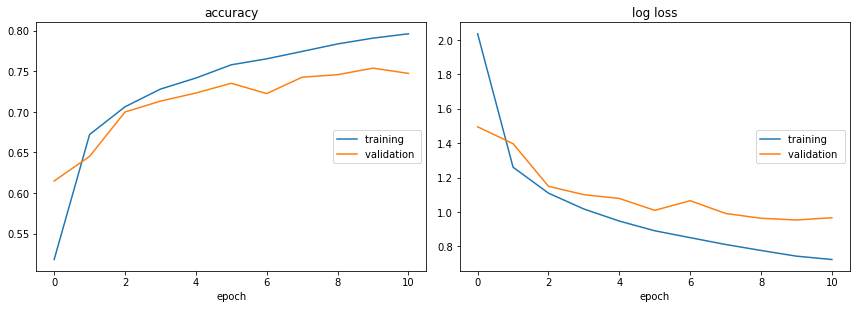

accuracy
	training         	 (min:    0.475, max:    0.796, cur:    0.796)
	validation       	 (min:    0.538, max:    0.754, cur:    0.747)
log loss
	training         	 (min:    0.723, max:    2.194, cur:    0.723)
	validation       	 (min:    0.953, max:    1.868, cur:    0.966)


In [0]:
optimizer = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
model, log = train_model(model_ft, optimizer, input_size, adaptive = adap)

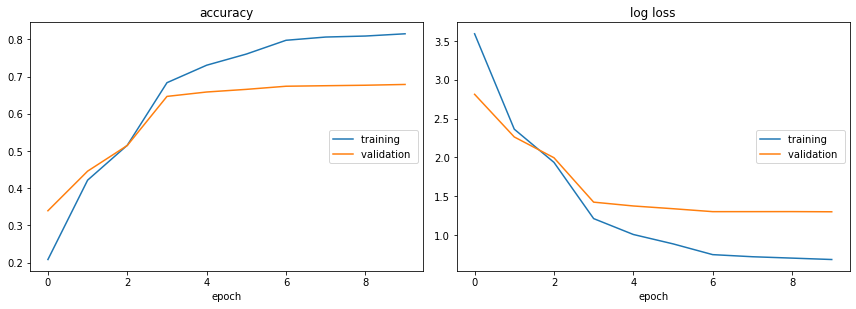

accuracy
	training         	 (min:    0.208, max:    0.815, cur:    0.815)
	validation       	 (min:    0.339, max:    0.679, cur:    0.679)
log loss
	training         	 (min:    0.685, max:    3.591, cur:    0.685)
	validation       	 (min:    1.300, max:    2.812, cur:    1.300)


In [0]:
# wide resnet50
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.256, momentum=momentum, weight_decay = 1e-5)
model, log = train_model(model_ft, optimizer, input_size)

In [0]:
torch.save(model_resnet, save_path + model_name + "_" + weight_decay + "_" + batch_size + "_" + lr + ".pth")

### 5. Test


#### Import testing data

In [0]:
import glob
from PIL import Image
import numpy as np
import pandas as pd
import json 

test_file = glob.glob('./test/images/*.JPEG') #'/content/drive/My Drive/Logistic/train/images/*.JPEG'
print(len(test_file))
test_data = []
test_names = []
for f in test_file:
    
    img = np.array(Image.open(f))
    test_name = f.split('/')[3][5:-5] #[7][5:-5] 
    #label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = np.stack((img,)*3, axis=-1)
    test_data.append(img)
    test_names.append(int(test_name))
print(test_names[:5])

#y_test is only used for generating dataset. it's not the real labels
y_test = np.array(test_names)
y_test = torch.tensor(y_test)
 
X_test = np.array(test_data)
X_test = torch.tensor(X_test).float()
X_test = X_test.permute(0,3,1,2)
 
test_set = CustomImageTensorDataset(X_test, y_test.long(), transform=valid_transform)
test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        num_workers=0,
        shuffle=False
)

#### Testing

In [0]:
y_pred, y_gt = evaluate(model_resnet, test_loader)
y_pred[:5], y_gt[:5]
res = {}
for i in range(10000):
    res["test_" + str(y_gt[i]) + ".jpeg"] = y_pred[i]
res
import csv
#'/content/drive/My Drive/Logistic/resnet50.csv'
with open(save_path + model_name + "_" + weight_decay + "_" + batch_size + "_" + lr + '.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Label"])
    for key, item in res.items():
        writer.writerow([key, item])